In [1]:
import numpy as np

In [2]:
import sys, glob

In [3]:
import matplotlib.pyplot as plt

In [4]:
from pycurrents.adcp.rdiraw import Multiread

In [5]:
import jdcal

In [6]:
import datetime

In [7]:
%matplotlib inline

## Load raw files using Multiread

In [169]:
pname = '/Volumes/wjlee_apl_2/2017_cruises/ADCP_RR1713/raw/os150/'
fname = glob.glob(pname+'rr2017_209*.raw')
fname

['/Volumes/wjlee_apl_2/2017_cruises/ADCP_RR1713/raw/os150/rr2017_209_00000.raw',
 '/Volumes/wjlee_apl_2/2017_cruises/ADCP_RR1713/raw/os150/rr2017_209_07200.raw',
 '/Volumes/wjlee_apl_2/2017_cruises/ADCP_RR1713/raw/os150/rr2017_209_14400.raw',
 '/Volumes/wjlee_apl_2/2017_cruises/ADCP_RR1713/raw/os150/rr2017_209_21600.raw',
 '/Volumes/wjlee_apl_2/2017_cruises/ADCP_RR1713/raw/os150/rr2017_209_28800.raw',
 '/Volumes/wjlee_apl_2/2017_cruises/ADCP_RR1713/raw/os150/rr2017_209_36000.raw',
 '/Volumes/wjlee_apl_2/2017_cruises/ADCP_RR1713/raw/os150/rr2017_209_43200.raw',
 '/Volumes/wjlee_apl_2/2017_cruises/ADCP_RR1713/raw/os150/rr2017_209_50400.raw',
 '/Volumes/wjlee_apl_2/2017_cruises/ADCP_RR1713/raw/os150/rr2017_209_62230.raw',
 '/Volumes/wjlee_apl_2/2017_cruises/ADCP_RR1713/raw/os150/rr2017_209_64800.raw',
 '/Volumes/wjlee_apl_2/2017_cruises/ADCP_RR1713/raw/os150/rr2017_209_72000.raw',
 '/Volumes/wjlee_apl_2/2017_cruises/ADCP_RR1713/raw/os150/rr2017_209_79200.raw']

In [170]:
m=Multiread(fname,'os')

In [171]:
data=m.read()

In [172]:
data.pingtype

'bb'

In [173]:
m.list_configs()

# index (ping, NCells, CellSize, Blank, Pulse) nfiles
0    (bb, 80, 4.0, 4.0, 4.0)     12
1    (nb, 60, 8.0, 4.0, 8.0)     12


In [174]:
data.sysconfig

{'angle': 30, 'convex': True, 'kHz': 150, 'up': False}

## Function to convert timestamp

In [175]:
def dday2timestr(yr,dday):
    ''' 
    Convert dday to str of timestamp
    yr     data.yearbase
    dday   one or more items in a list from data.dday
    '''
    yr1day = jdcal.gcal2jd(yr,1,1)  # get numbers for start of the year
    gcal = [jdcal.jd2gcal(yr1day[0],yr1day[1]+x) for x in np.nditer(dday)]
    td = [datetime.datetime(year=xx[0],month=xx[1],day=xx[2])+datetime.timedelta(days=xx[-1]) for xx in gcal]
    return [x.strftime('%H:%M:%S') for x in td]

## Seawater absorption

In [176]:
import arlpy
r = data.dep/np.cos(m.sysconfig['angle']*np.pi/180)  # convert depth to range [m]
SL = 20*np.log10(r)  # spreading loss
alpha_75k = arlpy.utils.mag2db(arlpy.uwa.absorption(75000,depth=100))      # seawater absorption at 75 kHz
alpha_150k = arlpy.utils.mag2db(arlpy.uwa.absorption(150000,depth=100))     # seawater absorption at 150 kHz
AB_75k = 2*alpha_75k*r/1000
AB_150k = 2*alpha_150k*r/1000

## Function to plot echogram

In [177]:
def plot_echogram(val_mtx,ping_num,time_str,depth):
    '''
    Plot echogram for inspection
    Note this is just for plotting, TL compensation is done outside of this function
    '''
    plt.figure(figsize=(12,3))
    plt.imshow(val_mtx.T,aspect='auto',interpolation='none',\
               extent=[0,val_mtx.shape[0],-depth[-1],-depth[0]],\
               vmin=100, vmax=300)
    plt.xticks(ping_num,time_str)
    plt.xlabel('Time (hr:min:sec)',fontsize='large')
    plt.ylabel('Depth (m)',fontsize='large')
    plt.ylim([-data.dep[-1],0])
    plt.colorbar()

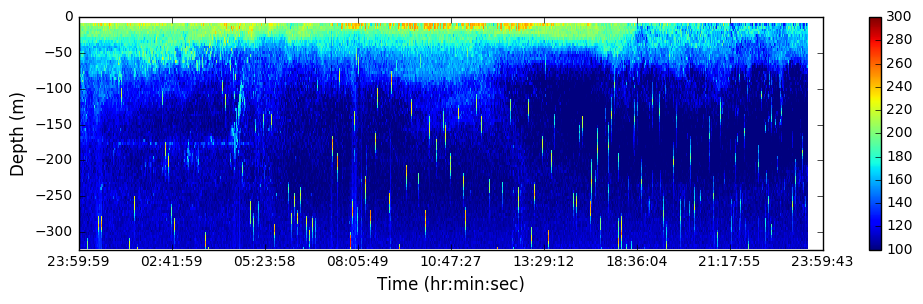

In [178]:
# set up x-axis
ping_jump = int(np.floor(data.dday.shape[0]/8))
ping_num = range(0,data.amp1.shape[0],ping_jump)
time_str = dday2timestr(data.yearbase,data.dday[::ping_jump])

# Plot TL-compensated echogram
plot_echogram(data.amp1+SL-AB_150k,ping_num,time_str,data.dep)

### Make xtick labels

In [49]:
ping_jump = 2000
xx_pingtime = data.dday[::ping_jump]  # every 1000th ping
xx_ticklabel = dday2timestr(data.yearbase,xx_pingtime)

### Plot raw amplitude using correct axes

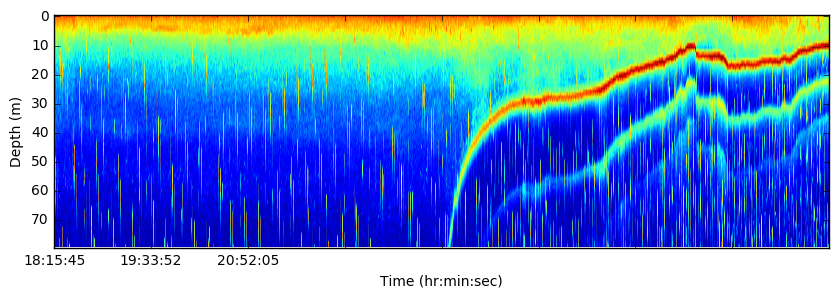

In [151]:
plt.figure(figsize=(10,3))
plt.imshow(data.amp1.T,aspect='auto')#,extent=[0,data.amp1.shape[0],-300,0])
plt.xticks(range(0,data.amp1.shape[0],ping_jump),xx_ticklabel)
#plt.yticks(range(0,data.amp1.shape[1],20),data.dep[::20])
plt.xlabel('Time (hr:min:sec)')
plt.ylabel('Depth (m)')

## Check transmission loss

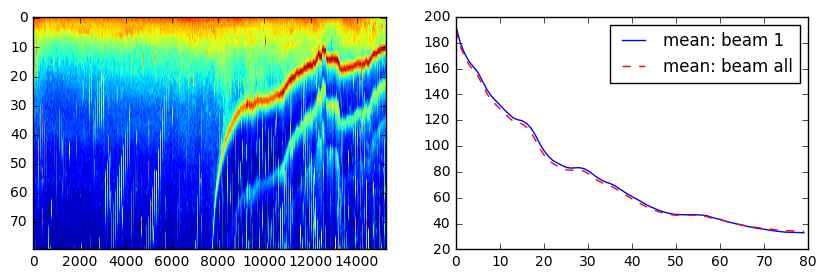

In [152]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.imshow(data.amp[:,:,1].T,aspect='auto')
plt.subplot(122)
plt.plot(np.mean(data.amp[:,:,1],axis=0),label='mean: beam 1')
plt.plot(np.mean(data.amp,axis=(0,2)),'r--',label='mean: beam all')
plt.legend()

## Experiment with compensating for TL

In [77]:
r = data.dep/np.cos(m.sysconfig['angle']*np.pi/180)
TL = 20*np.log10(r)
alpha = 100
A = 2*alpha*r/1000

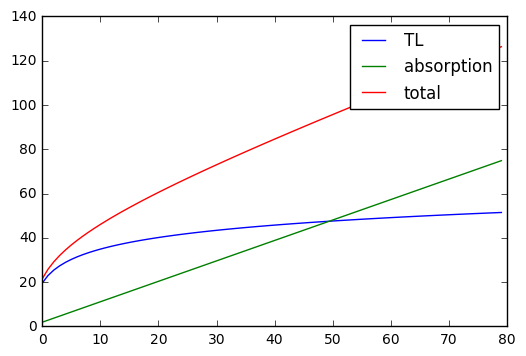

In [78]:
plt.plot(TL,label='TL')
plt.plot(A,label='absorption')
plt.plot(TL+A,'r',label='total')
plt.legend()

## Compare different compensation

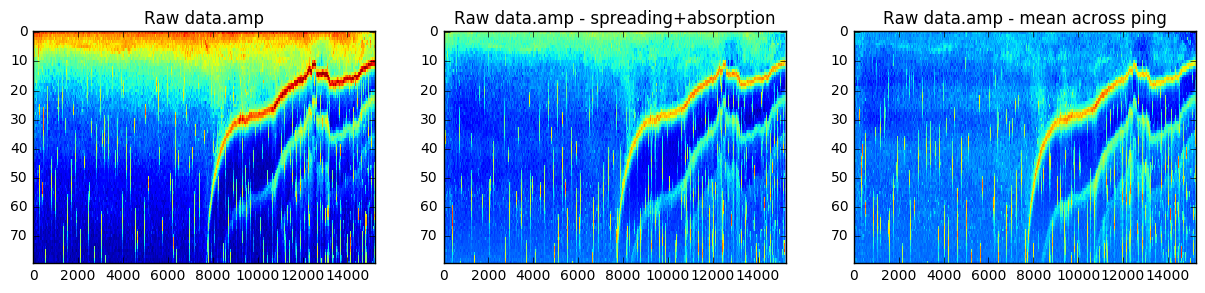

In [150]:
plt.figure(figsize=(15,3))
plt.subplot(131)
plt.imshow(data.amp[:,:,1].T,aspect='auto',interpolation='none')
plt.title('Raw data.amp')
plt.subplot(132)
plt.imshow((data.amp[:,:,1]+TL+A).T,aspect='auto',interpolation='none')
plt.title('Raw data.amp - spreading+absorption')
plt.subplot(133)
plt.imshow((data.amp[:,:,1]-np.mean(data.amp[:,:,1],axis=0)).T,aspect='auto',interpolation='none')
plt.title('Raw data.amp - mean across ping')